MLP model for predicting filtered shear stress and time to failure



> Input: Features at previous p timesteps [(t-p), ... , (t-2), (t-1), t]

> Output: Shear Stress and TTF at one timestep [t]



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import statistics
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Function to create data with timesteps

def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-2], data[end_ix-1, -2:]  #last column is assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)
 

In [3]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')

m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2),  'SS':data['SS'].ravel(), 'TTF':data['TTF'].ravel()})  
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'A_filt':data['A_filt'].ravel(), 'V_filt':data['V_filt'].ravel(),
                    'T_pc':data['T_pc'].ravel(), 'Vel_pc':data['Vel_pc'].ravel(), 'T_der':data['T_der'].ravel(), 'Vel_der':data['Vel_der'].ravel()})  

df = a_t.merge(m_t, on='Time')

print("Input data: ", df.shape)


Input data:  (132399, 9)


In [4]:
# Preprocessing

df = df.drop(['Time', 'Vel_der', 'T_der'], axis=1)   # Drop irrelevant features

arr = df.to_numpy()
n_steps = 300
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Reshape features from 3D to 2D (for input layer)

in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))


Features shape, X =  (132100, 300, 4)
Target shape, Y =  (132100, 2)
After reshaping, X =  (132100, 1200)


In [5]:
# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])


Training samples: 95112
Validation samples: 10568
Testing samples: 26420


Epoch 1/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.2339 - val_loss: 0.1684
Epoch 2/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0780 - val_loss: 0.0593
Epoch 3/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0577 - val_loss: 0.0727
Epoch 4/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0511 - val_loss: 0.0937
Epoch 5/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0477 - val_loss: 0.0596
Epoch 6/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0447 - val_loss: 0.0587
Epoch 7/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0427 - val_loss: 0.1022
Epoch 8/40
2973/2973 [==============================] - 6s 2ms/step - loss: 0.0418 - val_loss: 0.0732
Epoch 9/40
2973/2973 [==============================] - 7s 2ms/step - loss: 0.0400 - val_loss: 0.0629
Epoch 10/40
2973/2973 [==============================] - 7s 2ms/step - loss: 0.039

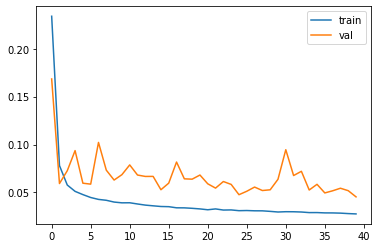

---Training time: 255.67071700 seconds ---


In [6]:
# Build the model

np.random.seed(0)   # To get reproducible results
tf.random.set_seed(1)

out_dim = ydf.shape[1]

model = Sequential()
model.add(Dense(512, kernel_initializer = 'normal', input_dim = in_dim, activation='relu'))
model.add(Dense(256, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(32, kernel_initializer = 'normal', activation='relu'))
model.add(Dense(out_dim, kernel_initializer = 'normal', activation='linear'))
model.compile(loss='mse', optimizer='adam')

start_time = time.time()
history = model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_data=(X_val, Y_val), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [7]:
# Evaluate the model

y_predTrain = model.predict(X_train)
ss_train_r2 = r2_score(Y_train[:,0], y_predTrain[:,0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train[:,0], y_predTrain[:,0]))
ttf_train_r2 = r2_score(Y_train[:,1], y_predTrain[:,1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train[:,1], y_predTrain[:,1]))

y_predVal = model.predict(X_val)
ss_val_r2 = r2_score(Y_val[:,0], y_predVal[:,0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val[:,0], y_predVal[:,0]))  
ttf_val_r2 = r2_score(Y_val[:,1], y_predVal[:,1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val[:,1], y_predVal[:,1]))

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
ss_test_r2 = r2_score(y_test[:,0], y_predTest[:,0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_predTest[:,0]))
ttf_test_r2 = r2_score(y_test[:,1], y_predTest[:,1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test[:,1], y_predTest[:,1]))

print("Shear Stress\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_r2, ss_val_r2, ss_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_rmse, ss_val_rmse, ss_test_rmse))

print("\nTTF\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_r2, ttf_val_r2, ttf_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_rmse, ttf_val_rmse, ttf_test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


Shear Stress
R2 scores: Train - 0.93685, Validation - 0.94155, Test - 0.87599
RMSE scores: Train - 0.03230, Validation - 0.03567, Test - 0.05088

TTF
R2 scores: Train - 0.95670, Validation - 0.93268, Test - 0.87672
RMSE scores: Train - 0.21811, Validation - 0.29910, Test - 0.40319

---Time for Test data prediction: 0.79336357 seconds ---


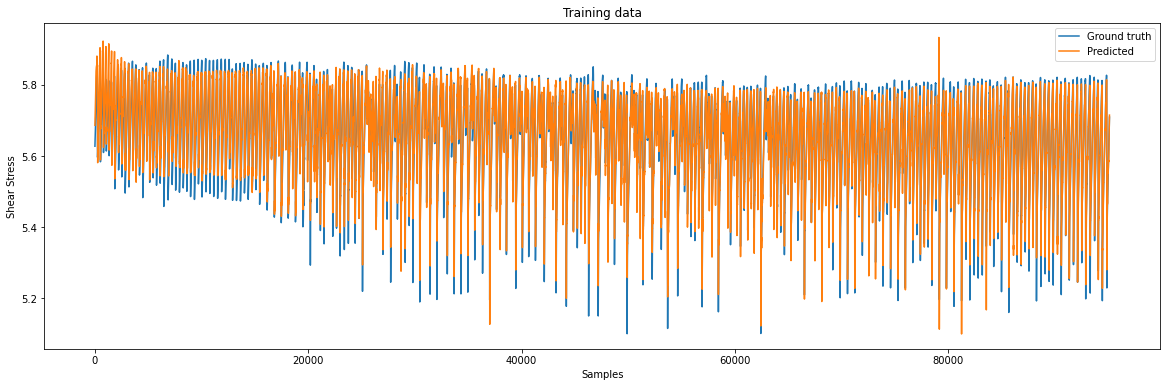

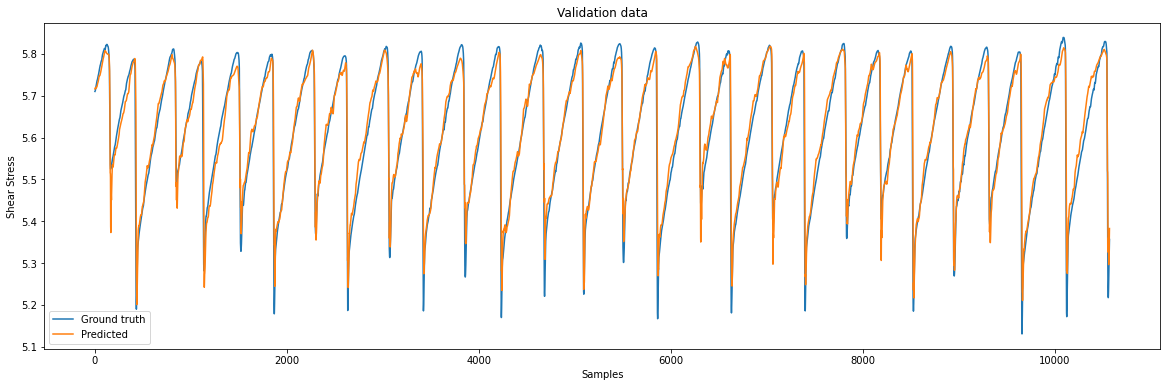

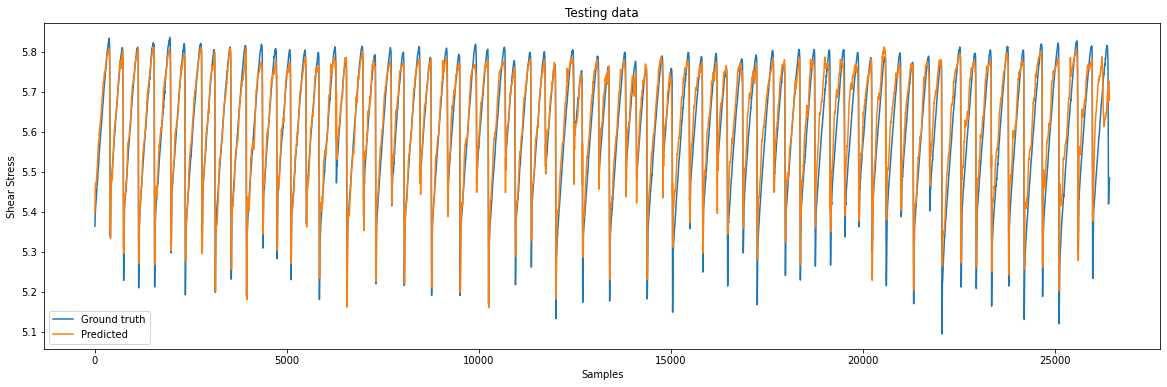

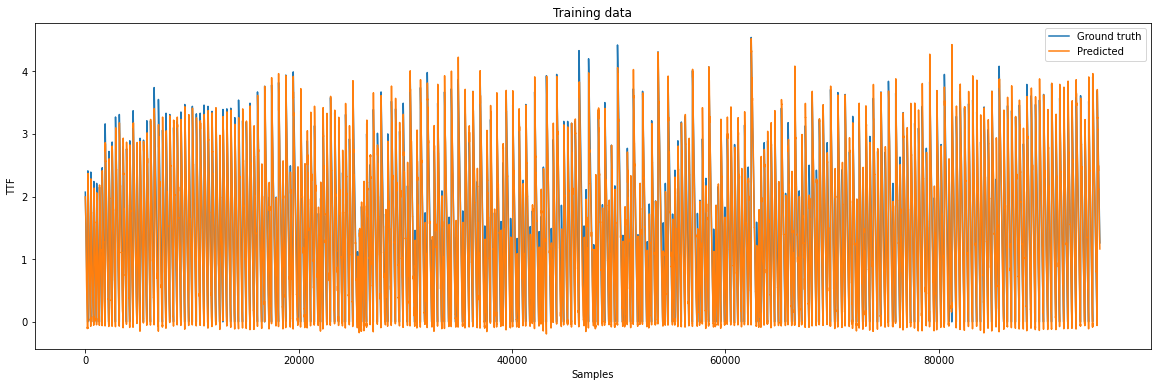

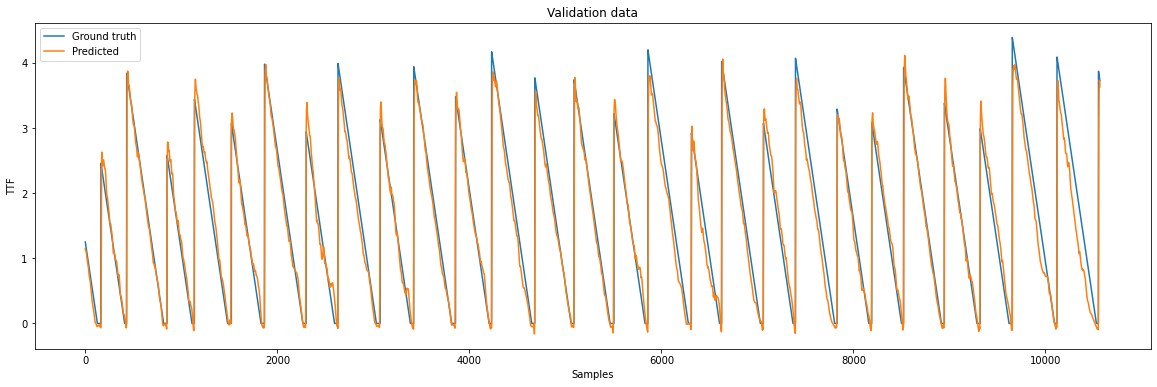

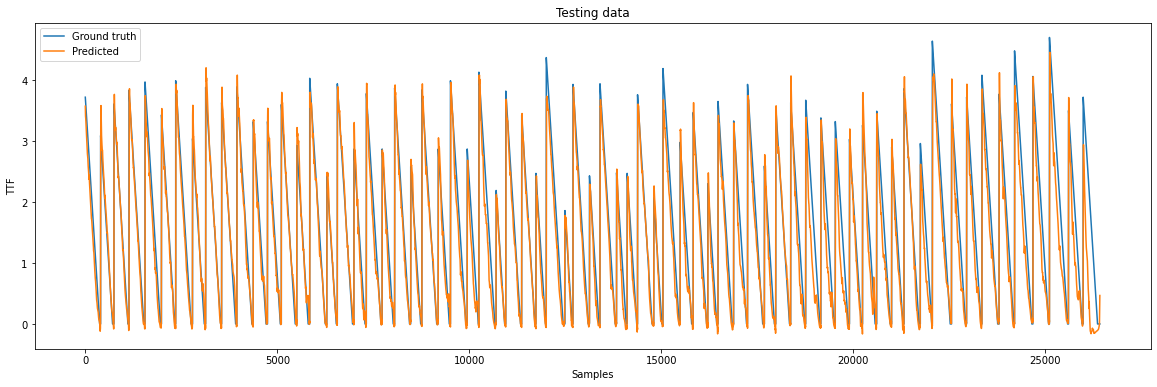

In [8]:
# Results plot

def results_plot(fig_no, gt, pred, title, ylabel):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Samples')
  plt.ylabel(ylabel)
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train[:,0], y_predTrain[:,0], 'Training data', 'Shear Stress')
results_plot(2, Y_val[:,0], y_predVal[:,0], 'Validation data', 'Shear Stress')
results_plot(3, y_test[:,0], y_predTest[:,0], 'Testing data', 'Shear Stress')
results_plot(4, Y_train[:,1], y_predTrain[:,1], 'Training data', 'TTF')
results_plot(5, Y_val[:,1], y_predVal[:,1], 'Validation data', 'TTF')
results_plot(6, y_test[:,1], y_predTest[:,1], 'Testing data', 'TTF')


Text(0.5, 1.0, 'Detailed View, Testing Data')

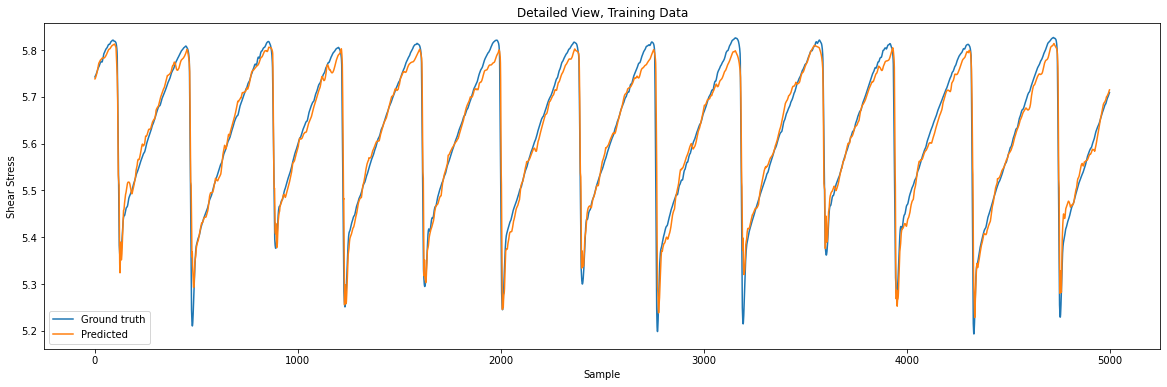

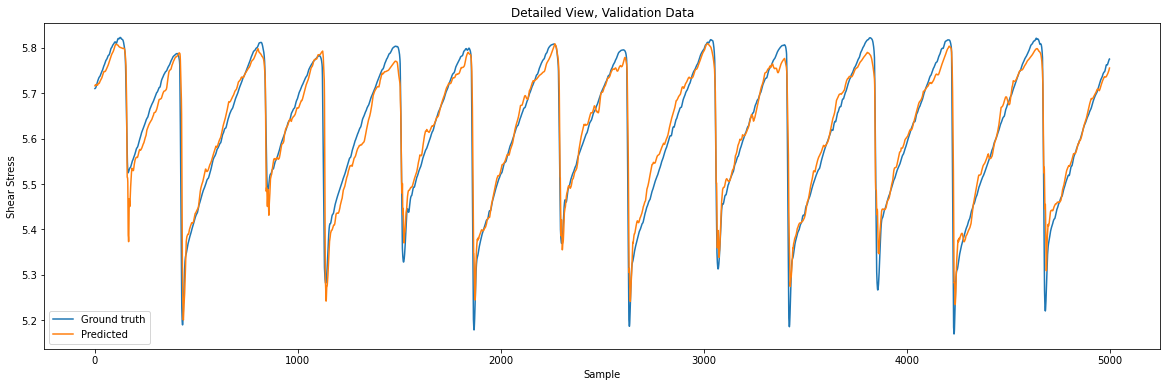

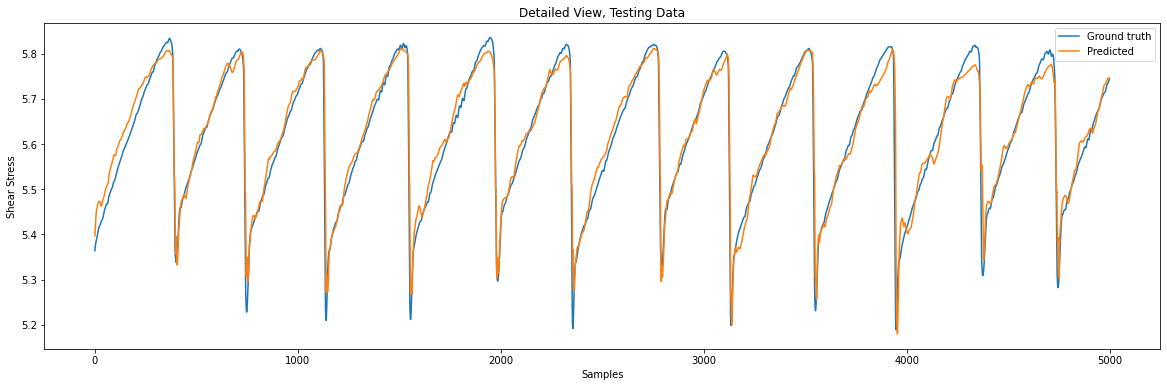

In [9]:
# Detailed view of SS plots

n=5000

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-n:,0])
plt.plot(y_predTrain[-n:,0])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:n,0])
plt.plot(y_predVal[:n,0])
plt.xlabel('Sample')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:n,0])
plt.plot(y_predTest[:n,0])
plt.xlabel('Samples')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'Detailed View, Testing Data')

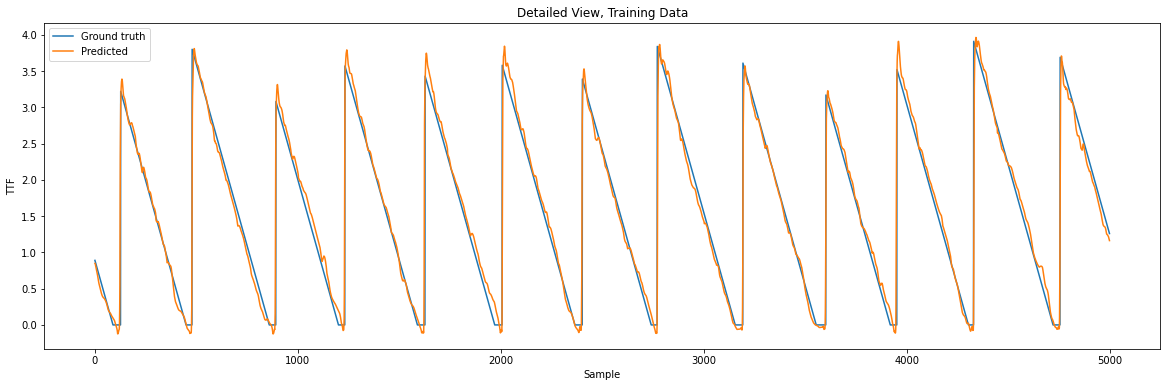

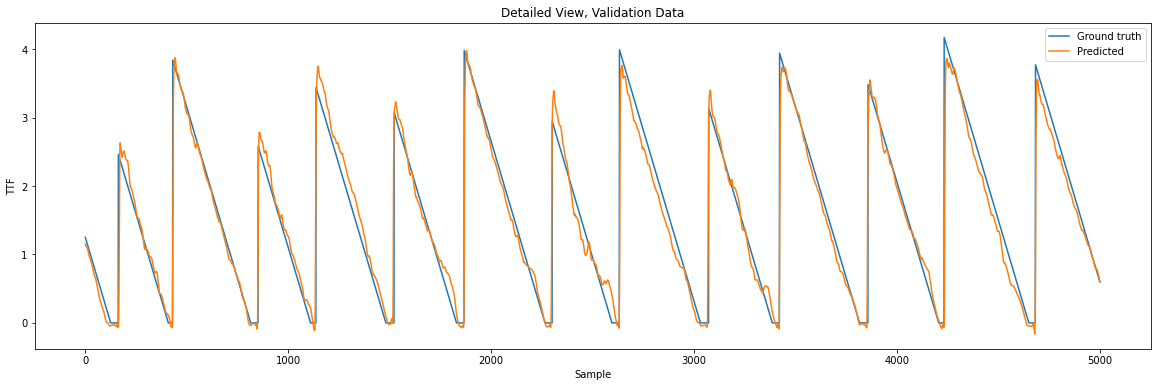

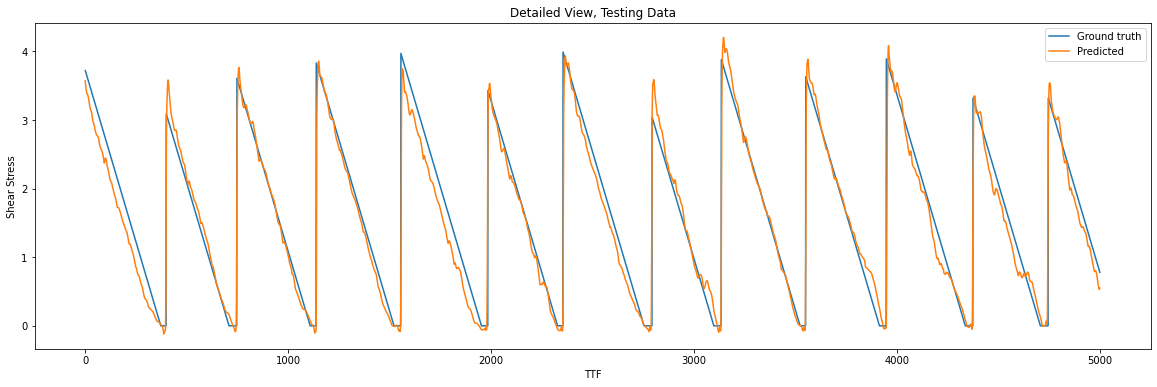

In [10]:
# Detailed view of TTF plots

n=5000

fig = plt.figure(4, figsize=(20,6))
plt.plot(Y_train[-n:,1])
plt.plot(y_predTrain[-n:,1])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(Y_val[:n,1])
plt.plot(y_predVal[:n,1])
plt.xlabel('Sample')
plt.ylabel('TTF')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

fig = plt.figure(6, figsize=(20,6))
plt.plot(y_test[:n,1])
plt.plot(y_predTest[:n,1])
plt.xlabel('TTF')
plt.ylabel('Shear Stress')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'TTF')

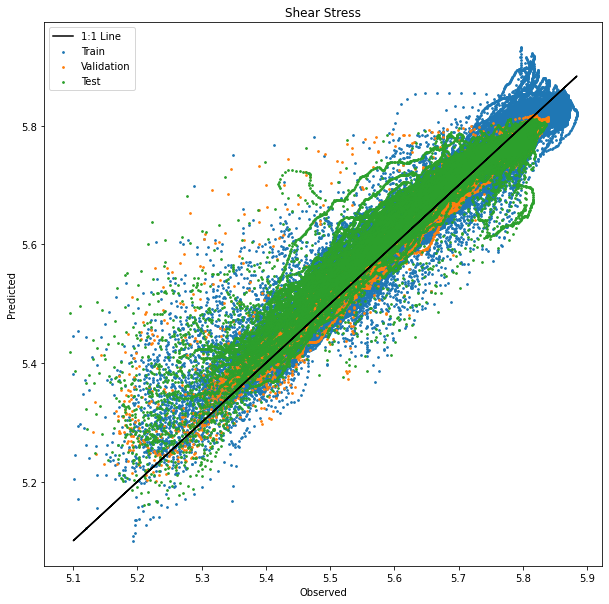

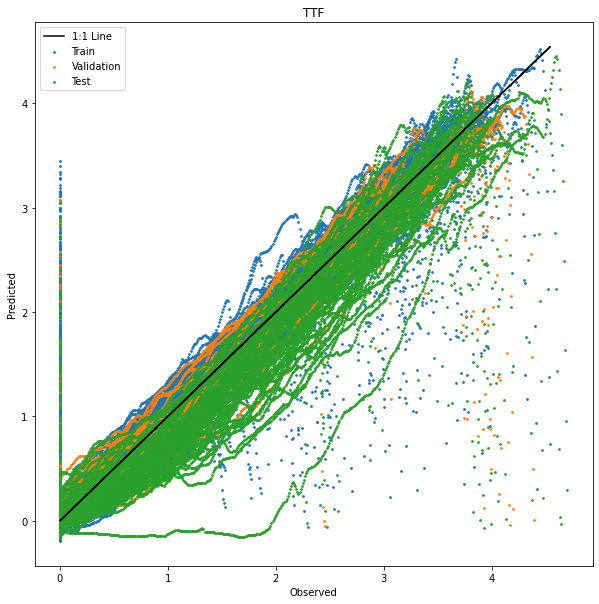

In [11]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train[:,0], Y_train[:,0], 'black')
plt.scatter(Y_train[:,0], y_predTrain[:,0], s=3)
plt.scatter(Y_val[:,0], y_predVal[:,0], s=3)
plt.scatter(y_test[:,0], y_predTest[:,0], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')

fig = plt.figure(8, figsize=(10,10))
plt.plot(Y_train[:,1], Y_train[:,1], 'black')
plt.scatter(Y_train[:,1], y_predTrain[:,1], s=3)
plt.scatter(Y_val[:,1], y_predVal[:,1], s=3)
plt.scatter(y_test[:,1], y_predTest[:,1], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('TTF')

